In [1]:
"""
Configs:
    # Env
    env_id="Gridworld03-v01", size=4x4, action_reward=[-12, 10], terminal_reward=5
     - once in the goal state, each action ends the episode and returns a reward of 5
     - no clear episodes, continuously train the agent with num_train_steps, 
       if the agent reaches terminal, just reset environment and keep training 
    # Params
    eps_sched_fn=poly(0.5), lr_sched_fn=poly(0.8)
    # Algos
    haver2, action_sigma=adaptive(1), haver_delta=0.01, haver_const=varied
Status:
"""

from collections import defaultdict
import random
import numpy as np
np.set_printoptions(precision=2, suppress=True)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import time
from tqdm import tqdm 
import multiprocessing

# import gymnasium as gym
import gym
import gym_examples
from gym.wrappers import FlattenObservation

from algos import *
from utils import *

In [2]:

random.seed(123)
np.random.seed(123)
tdqm_disable = True

# params
env_id = "gym_examples/GridWorld05-v1"
gridworld_size = 3
max_steps = 20
gamma = 0.95

num_trials = 200
num_steps_train = 5000

lr_sched_type = "linear"
lr_sched_fn = create_lr_sched_fn(lr_sched_type)

max_eps = 1.0
min_eps = 0.001
decay_rate = 0.0001
eps_sched_type = "fixed"
eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)

haver_const = 1.0
est_name = "haver" 
q_algo_name = "haver_q_learning"
q_algo = create_q_algo(q_algo_name)

# create gym env
num_action_p = 1
action_mu = 0.0
action_sigma = 1.0
action_params = [action_mu, action_sigma]
terminal_reward = 5.0
env = gym.make(env_id, size=gridworld_size, num_actions_p=num_action_p,
               action_params=action_params, terminal_reward=terminal_reward)
env_wrapped = FlattenObservation(env)
num_actions = env_wrapped.action_space.n
print(f"num_actions = {num_actions}")
# print(env_wrapped.reset())
# stop

action_mu = action_params[0]
optimal_num_steps = gridworld_size*2-1
optimal_vstar = terminal_reward*gamma**(optimal_num_steps-1) \
    + action_mu*np.sum([gamma**k for k in range(optimal_num_steps-1)])
optimal_reward_per_step = (terminal_reward + action_mu*(optimal_num_steps-1))/optimal_num_steps  
print(f"optimal_num_steps = {optimal_num_steps}")
print(f"optimal_reward_per_step = {optimal_reward_per_step}")
print(f"optimal_vstar = {optimal_vstar:.3f}")

manager = multiprocessing.Manager()
episode_start_sigmahats_list = manager.list()
episode_rewards_list = manager.list()
episode_vstar_est_list = manager.list()
Q_table_list = manager.list()
Q_nvisits_list = manager.list()    

def run_trial(i_trial, args):

    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

    # env = gym.make(env_id, size=gridworld_size)
    # env_wrapped = FlattenObservation(env)
    # env_wrapped.reset(seed=10000+i_trial)

    # lr_sched_fn = create_lr_sched_fn(lr_sched_type)
    # eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)
    q_algo = create_q_algo(args["est_name"])

    Q_table, Q_nvisits, stats = q_algo(
        env_wrapped, num_actions, num_steps_train,
        gamma, lr_sched_fn, eps_sched_fn, tdqm_disable, args)

    episode_start_sigmahats, episode_rewards, episode_vstar_est= zip(*stats)
    episode_start_sigmahats_list.append(episode_start_sigmahats)
    episode_rewards_list.append(episode_rewards)
    episode_vstar_est_list.append(episode_vstar_est)
    Q_table_list.append(Q_table)
    Q_nvisits_list.append(Q_nvisits)

args = dict()
args["action_sigma"] = action_sigma
args["haver_alpha"] = 2.0
args["haver_delta"] = 0.05
args["haver_const"] = 1.0
args["weightedms_num_data"] = 1000

pool = multiprocessing.Pool()

episode_start_sigmahats_dict = defaultdict()
episode_rewards_dict = defaultdict()
episode_vstar_est_dict = defaultdict()
episode_vstar_est_bias_dict = defaultdict()
episode_vstar_est_var_dict = defaultdict()
episode_vstar_est_mse_dict = defaultdict()
Q_table_dict = defaultdict()
Q_nvisits_dict = defaultdict()

haver_const_ary = [1.0]
haver_name_ary = [f"haver_{x}" for x in haver_const_ary]
haver3_name_ary = [f"haver3_{x}" for x in haver_const_ary]

est_name_ary = ["max", "weightedms"]
# est_name_ary = est_name_ary + haver_name_ary
est_name_ary = est_name_ary + haver3_name_ary
# est_name_ary = ["max"]
for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    if "haver" in est_name:
        elems = est_name.split("_")
        args["est_name"] = elems[0]
        args["haver_const"] = float(elems[-1])
        print(f"haver_const = {args['haver_const']}")
    else:
        args["est_name"] = est_name
    
    pool.starmap(run_trial, [(i, args) for i in range(num_trials)])

    episode_start_sigmahats_ary = np.hstack([episode_start_sigmahats_list])
    episode_rewards_ary = np.hstack([episode_rewards_list])
    episode_vstar_est_ary = np.hstack([episode_vstar_est_list])

    episode_start_sigmahats_dict[est_name] = np.mean(episode_start_sigmahats_ary, 0)
    episode_rewards_dict[est_name] = np.mean(episode_rewards_ary, 0)
    episode_vstar_est_dict[est_name] = np.mean(episode_vstar_est_ary, 0)
    print(f"last_episode_start_sigmahat = {episode_start_sigmahats_dict[est_name][-1]:.4f}")
    print(f"last_episode_reward_per_step = {episode_rewards_dict[est_name][-1]:.4f}")
    print(f"last_episode_estim_start_muhat = {episode_vstar_est_dict[est_name][-1]:.4f}")
    
    episode_vstar_est_bias_dict[est_name] = np.mean(episode_vstar_est_ary - optimal_vstar, 0)
    episode_vstar_est_var_dict[est_name] = np.var(episode_vstar_est_ary - optimal_vstar, 0, ddof=1)
    episode_vstar_est_mse_dict[est_name] = \
        episode_vstar_est_bias_dict[est_name]**2 \
        + episode_vstar_est_var_dict[est_name]
    
    # Q_table_dict[est_name] = np.mean(np.stack(Q_table_list), 0)
    # Q_nvisits_dict[est_name] = np.mean(np.stack(Q_nvisits_list), 0)
    # print(np.stack(Q_table_list).shape)
    Q_table_dict[est_name] = np.stack(Q_table_list)[0,:,:,:]
    Q_nvisits_dict[est_name] = np.stack(Q_nvisits_list)[0,:,:,:]
    # print(Q_table_list[0][0,0,:])
    # print(Q_table_list[1][0,0,:])
    # print(Q_table_ary)
    # stop
                           
    episode_start_sigmahats_list[:] = []
    episode_rewards_list[:] = []
    episode_vstar_est_list[:] = []
    Q_table_list[:] = []
    Q_nvisits_list[:] = []
    
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")


num_actions = 4
optimal_num_steps = 5
optimal_reward_per_step = 1.0
optimal_vstar = 4.073

-> est_name = max
last_episode_start_sigmahat = 2357.8550
last_episode_reward_per_step = 0.1721
last_episode_estim_start_muhat = 1.5916
it takes 22.4650

-> est_name = weightedms
last_episode_start_sigmahat = 1779.8550
last_episode_reward_per_step = 0.5520
last_episode_estim_start_muhat = -0.6433
it takes 62.6816

-> est_name = haver_1.0
haver_const = 1.0
last_episode_start_sigmahat = 1905.1800
last_episode_reward_per_step = 0.2445
last_episode_estim_start_muhat = 0.7820
it takes 30.5707

-> est_name = haver3_1.0
haver_const = 1.0
last_episode_start_sigmahat = 1905.2300
last_episode_reward_per_step = 0.2271
last_episode_estim_start_muhat = 0.7809
it takes 33.0967


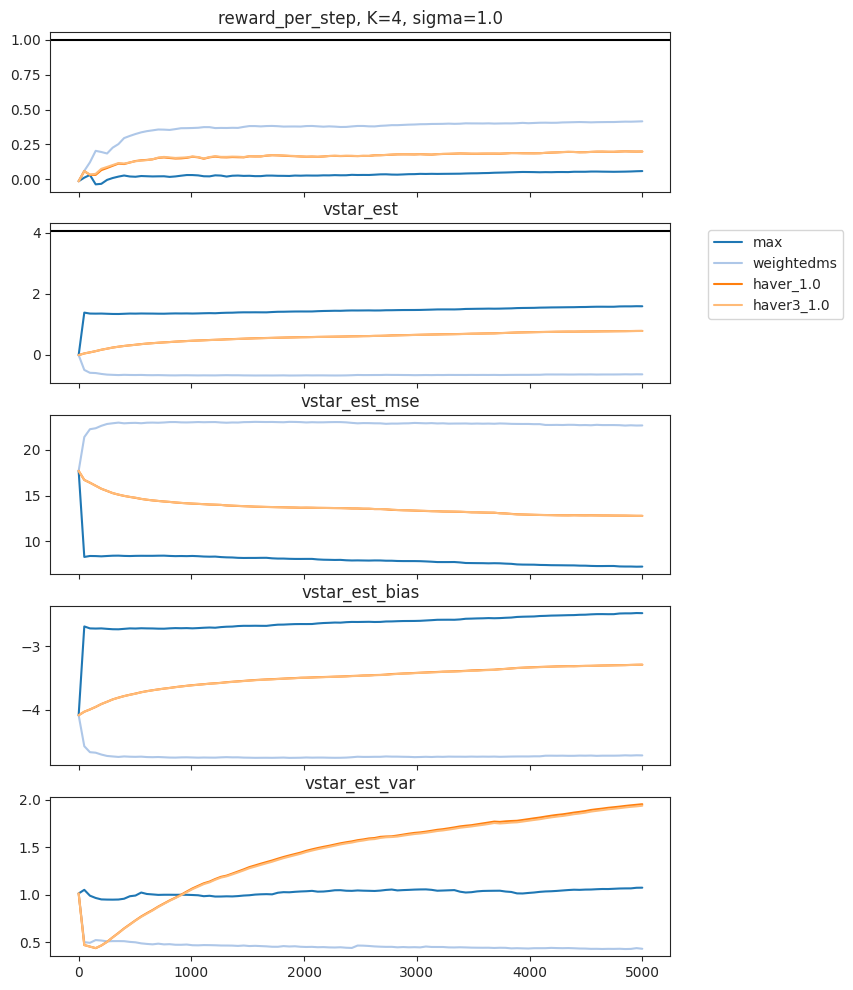

In [3]:

fig, axes = fig, axes = plt.subplots(
        nrows=5, ncols=1, sharex=True, sharey=False, figsize=(8,12))
# axes = [axes]

x_ary = np.linspace(0, num_steps_train-1, num=100, dtype=np.int32)
# est_name_ary = ["weightedms"]
est_name_ary_unwanted = []
est_name_ary_wanted = [est_name for est_name in est_name_ary[:8] \
                 if est_name not in est_name_ary_unwanted]
for est_name in est_name_ary_wanted:
    # axes[0].plot(x_ary, episode_rewards_dict[est_name][x_ary], label=est_name)
    y_ary = running_avg(episode_rewards_dict[est_name][x_ary], 100)
    axes[0].plot(
        x_ary, y_ary, label=est_name)
    axes[1].plot(x_ary, episode_vstar_est_dict[est_name][x_ary], label=est_name)
    axes[2].plot(x_ary, episode_vstar_est_mse_dict[est_name][x_ary], label=est_name)
    axes[3].plot(x_ary, episode_vstar_est_bias_dict[est_name][x_ary], label=est_name)
    axes[4].plot(x_ary, episode_vstar_est_var_dict[est_name][x_ary], label=est_name)

axes[0].axhline(y=optimal_reward_per_step, color="black")
axes[1].axhline(y=optimal_vstar, color="black")
axes[0].set_title(f"reward_per_step, K={num_actions}, sigma={action_sigma}")
axes[1].set_title("vstar_est")
axes[2].set_title("vstar_est_mse")
axes[3].set_title("vstar_est_bias")
axes[4].set_title("vstar_est_var")
# axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axes[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

NameError: name 'episode_rewards_mean_dict' is not defined

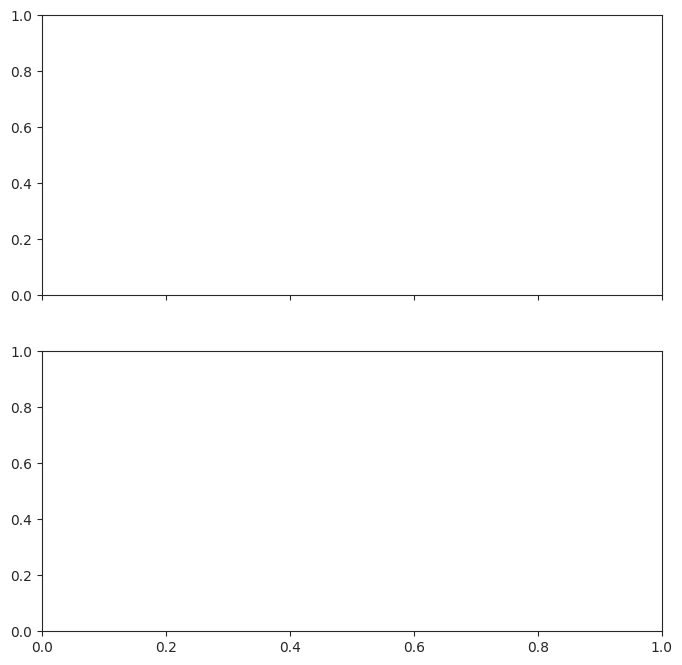

In [4]:

fig, axes = fig, axes = plt.subplots(
        nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))
# axes = [axes]

x_ary = np.linspace(0, num_steps_train-1, num=1000, dtype=np.int32)
for est_name in est_name_ary[:4]:
    # axes[0].plot(x_ary, episode_rewards_mean_dict[est_name][x_ary], label=est_name)
    y_ary = running_avg(episode_rewards_mean_dict[est_name][x_ary], 100)
    axes[0].plot(
        x_ary, y_ary, label=est_name)
    axes[1].plot(x_ary, episode_start_muhats_mean_dict[est_name][x_ary], label=est_name)
    # axes[2].plot(x_ary, episode_start_sigmahats_mean_dict[est_name][x_ary], label=est_name)


axes[0].axhline(y=optimal_reward_per_step, color="black")
axes[1].axhline(y=optimal_vstar, color="black")
axes[0].set_title(f"reward_per_step, mu={action_reward[0]}, sigma={action_reward[1]}")
axes[1].set_title(f"estim_qval_start_state")
# axes[2].set_title("episode_length")
axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axes[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
# fig, axes = fig, axes = plt.subplots(
#         nrows=1, ncols=1, sharex=True, sharey=False, figsize=(8,8))
# axes = [axes]

# x_ary = np.linspace(2000, num_steps_train-1, num=1000, dtype=np.int32)
# # est_name_ary2 = haver_name_ary + ["weightedms"]
# for est_name in est_name_ary:
#     axes[0].plot(x_ary, episode_start_sigmahats_mean_dict[est_name][x_ary], label=est_name)

# axes[0].set_title("Q_sigmahat")
# # axes[0].set_ylim([0, 1])
# axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show()

In [ ]:

# for est_name in est_name_ary:
#     print(f"\n-> est_name = {est_name}")
#     Q_table = Q_table_dict[est_name]
#     Q_nvisits = Q_nvisits_dict[est_name]
#     for i_row in range(gridworld_size):
#         for j_col in range(gridworld_size):
#             print(f"{i_row} {j_col}: {Q_table[i_row,j_col]}, {Q_nvisits[i_row,j_col]}")
